# Titanic Using SVM - Kaggle Competition

Author: Szymon Pawłowski\
Date: 10.01.2021r.

# Kaggle Titanic Competition
It is one of the first challenges every ML beginner should dive in. \
In this competition the main goal is to predict which passengers survived the Titanic shipwreck \
using given data and creating a ML model. Here the SVM is used for prediction. 

# The data
The data has been split into two groups: training set and test set. Columns they contain:
* Survival - did passenger survive - 0=no, 1=yes
* Pclass - ticket class - 1=1st, 2=2nd, 3=3rd
* Name 
* Sex - sex - m/f 
* Age - age in years
* Sibsp - number of siblings / spouses aboard the Titanic 
* Parch - number of parents / children aboard the Titanic 
* Ticket - ticket number 
* Fare - passenger fare
* Cabin - cabin number 
* Embarked - port of embarkation - C=Cherbourg, Q=Quennstown, S=Southampton

# Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Loading data and first sight into it

In [2]:
#Loading data
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
#Combining into one data frame
df = pd.concat([train,test])

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


We can see that Cabin has only 295 non-null observations from 1309. It is too hard to handle those NA's so we will have remove this predictor (either way it was also hard to get information from it). What is more, we need to change object types into binary classification. From Name we can extract special titles which can improve our model. What is more, from SibSp and Parch we can get information about family size and categorize it. Let's see what our data say to us. For that we will exclude PassengerId and Cabin

In [7]:
df1 = df.drop(["PassengerId","Cabin","Ticket"],axis=1)

# Exploratory Data Analysis (EDA)

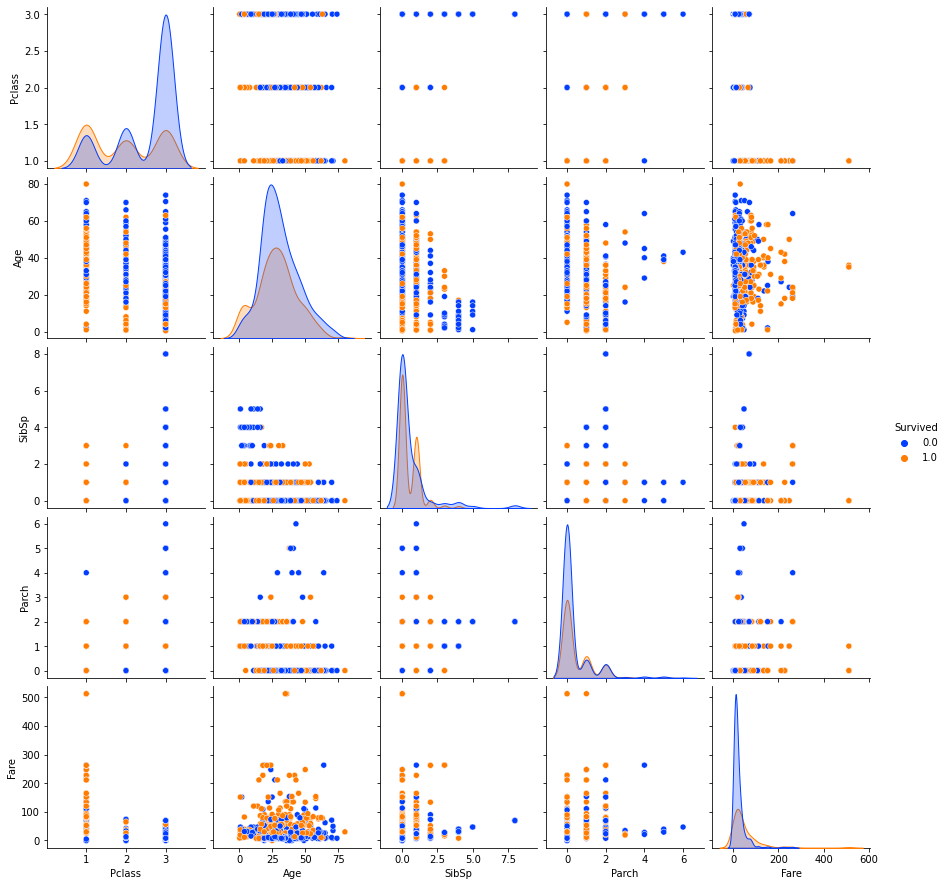

In [8]:
sns.pairplot(df1, hue="Survived", dropna=True,palette="bright")

<AxesSubplot:>

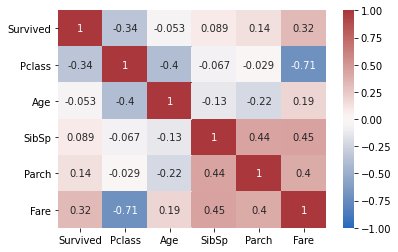

In [9]:
sns.heatmap(df1.corr(method='spearman'), annot=True, vmin=-1, vmax=1, cmap="vlag")

We can notice that:
* Fare is positively correlated with Survived
* Parch and SibSp are highly correlated with Fare
* Survived and Pclass are negatively correlated \
Correlation between rest of the variables is closely to 0 but we will get back to it after some features engingeering. 

**Pclass**

In [10]:
sns.distplot(df1, x="Pclass", hue="Survived", multiple="dodge",palette="bright")

TypeError: distplot() got an unexpected keyword argument 'hue'

We see that in the 1st class there were more survivors and that in the 3rd class we have the opposite situation. Probably those in the first class are better situated and constructed. They might be placed nearby rescue cabins. This variable might be valuable predictor.

**Sex**

In [ ]:
sns.displot(df1, x="Sex", hue="Survived", palette="bright")

Most of the survivors were females. This is a well-known fact that women with children are in the first place to be saved.

**Age**

In [ ]:
sns.displot(df1, x="Age", hue="Survived",kind="kde", palette="bright",multiple="stack")

Because of the low correlation it is hard to tell something valuable. Most survivors were between age of 20 and 30, similarly the non-survivrors. Later we will try to categorize age and check out if we can get more informations.

**Fare**

In [ ]:
sns.displot(df1, x="Fare", hue="Survived",palette="bright",multiple="stack")

We can notice that most of non-survivors are in the range of low Fare. Survivors are more spreaded and probably there is also an outlier. The less is the charge the less survivors comparing to non-survivors. It might be caused with a fact that well paid cabins could be more durable or be placed closer to rescue boats.

**Embarked**

In [ ]:
df1['Embarked'].fillna(random.choice("SQC"), inplace=True) #getting rid of 2 NA's by random choice

In [ ]:
sns.displot(df1, x="Embarked", hue="Survived", palette="bright")

As we can see in Queenstown or Southampton most Fares are in the low interval while in the Cherbourg we may notice that Fares were aswell low as high so the reason standing behind more survivors in Cherbourg are probably better paid cabins.

# Feature Engineering

**Sex**

In [29]:
#Changing into binary variable
df1.Sex[df1.Sex=="male"] = -1
df1.Sex[df1.Sex=="female"] = 1

**Embarked**

In [30]:
df1.Embarked[df1.Embarked.isna()==True]=random.choice(["C","Q","S"])
#Changing into binary variable
df1.Embarked[df1.Embarked=="C"] = -1
df1.Embarked[df1.Embarked=="Q"] = 0
df1.Embarked[df1.Embarked=="S"] = 1

**Family Size**

In [31]:
df1["FS"] = df1.Parch + df1.SibSp

df1.FS[df1.FS==1] = -1 #single
df1.FS[(1<df1.FS) & (df1.FS<5)] = 0 #family
df1.FS[df1.FS>=5] = 1 #large family

**Fare**

In [32]:
df1.Fare[df1.Fare.isnull()==True] = df1.Fare.median()


**Titles**

In [33]:
df1["Titles"]=df1.Name.str.extract('([A-Za-z]+)\.',expand=False) #extracting titles

In [34]:
df1.Titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [35]:
df1["TitlesBi"] = df1.Titles
df1.TitlesBi[df1.Titles.isin(["Mr","Mrs"])] = -1
df1.TitlesBi[df1.Titles.isin(["Ms","Miss"])] = 0
df1.TitlesBi[~df1.Titles.isin(["Mr","Mrs","Ms","Miss"])] = 1

In [36]:
#Dropping column Name
df1 = df1.drop(["Name","Titles"],axis=1)

**Age**

<AxesSubplot:xlabel='Age'>

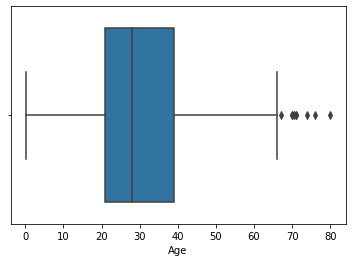

In [37]:
sns.boxplot(df1.Age)

<AxesSubplot:xlabel='Age', ylabel='Density'>

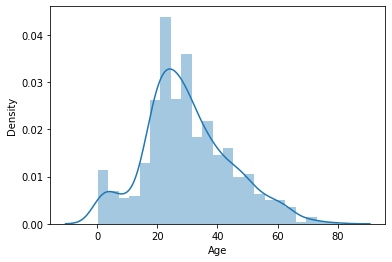

In [38]:
sns.distplot(df1.Age)

We see that our data is skewed and there are outliers so we should not use mean for replacing NA's. Instead we will use mode() which replaces NA's with the most frequent data.

In [39]:
df1.Age[df1.Age.isnull()==True] = df1.Age.median()

In [40]:
df2 = df1.copy()

So we got rid off the missing values. Next, we will change Age and Fare into binary variables but save them as different data frame to see which model will do better.

In [41]:
#Fare
df2.Fare[df2.Fare<=np.quantile(df2.Fare,0.25)] = -1
df2.Fare[(df2.Fare>np.quantile(df2.Fare,0.25)) & (df2.Fare<=np.quantile(df2.Fare,0.75))] = 0
df2.Fare[df2.Fare>np.quantile(df2.Fare, 0.75)] = 1

In [42]:
#Age
df2.Age[df2.Age<=18] = -1 #Child
df2.Age[(df2.Age>18) & (df2.Age <=50)] = 0 #Adult
df2.Age[df2.Age>50] = 1 #Elderly

In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   FS        1309 non-null   int64  
 9   TitlesBi  1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 112.5+ KB


In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   FS        1309 non-null   int64  
 9   TitlesBi  1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 112.5+ KB


In [45]:
#

Finally we have cleaned up the data. We got rid of the missing values, changed most values into numerical binary variables and got new features like FS or Titles. Now we are going to fit a model and make some predictions!

# Model fitting

In [46]:
#Get rid of test data we combined
df_train1 = df1[df1.Survived.isnull()==False]
df_train2 = df2[df2.Survived.isnull()==False]

df_test1 = df1[df1.Survived.isnull()==True]
df_test2 = df2[df2.Survived.isnull()==True]

In [47]:
df2.isna().sum()

Survived    418
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FS            0
TitlesBi      0
dtype: int64

In [48]:
#splitting train into test and train data
x1 = df_train1.drop(["Survived"],axis=1)
x2 = df_train2.drop(["Survived"],axis=1)

y1=df_train1.Survived
y2=df_train2.Survived

In [49]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.33)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.33)

In [50]:
clf = svm.SVC()

In [51]:
lab_enc = preprocessing.LabelEncoder()
y1_train_e = lab_enc.fit_transform(y1_train)
y2_train_e = lab_enc.fit_transform(y2_train)

In [381]:
fitting1 = clf.fit(x1_train,y1_train_e)
fitting2 = clf.fit(x2_train,y2_train_e)

In [382]:
y1_pred = clf.predict(x1_test)
y2_pred = clf.predict(x2_test)

In [383]:
print(confusion_matrix(y1_test,y1_pred))
print(classification_report(y1_test,y1_pred))

[[172   0]
 [123   0]]
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       172
         1.0       0.00      0.00      0.00       123

    accuracy                           0.58       295
   macro avg       0.29      0.50      0.37       295
weighted avg       0.34      0.58      0.43       295



In [384]:
print(confusion_matrix(y2_test,y2_pred))
print(classification_report(y2_test,y2_pred))

[[149  29]
 [ 32  85]]
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       178
         1.0       0.75      0.73      0.74       117

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



We got really high score of predicting for df2. From this we can conclude that binary variables are affecting in better predictions. Next we will make prediction which we are going to submit on Kaggle

In [385]:
predictors_t = df_train2.drop(["Survived"],axis=1)
predicted_t = df_train2.Survived

predictors = df_test2.drop(["Survived"],axis=1)
predicted = df_test2.Survived

In [386]:
predicted_t_e = lab_enc.fit_transform(predicted_t)
fit = clf.fit(predictors_t,predicted_t_e)

In [387]:
predicted = clf.predict(predictors)

In [388]:
submission = pd.DataFrame({ 'PassengerId': test.PassengerId,
                            'Survived': predicted })
submission.to_csv("submission.csv", index=False)

# USING PCA

In [52]:
dfpca = df2[df2.Survived.isna()==False]
dfpca_d = dfpca.drop("Survived",axis=1)
dfpca_t = dfpca["Survived"]

In [53]:
dfpca_target = df2["Survived"]
dfpca_data = df2.drop("Survived",axis=1)

In [55]:
#Scaling the data
scaler1=StandardScaler()
scaler1.fit(dfpca_data)
feature_scaled=scaler1.transform(dfpca_data)
feature_scaled

array([[ 0.84191642, -0.74349692,  0.16168271, ...,  0.62416693,
        -1.90184416, -0.56478476],
       [-1.54609786,  1.34499549,  0.16168271, ..., -1.83307973,
        -1.90184416, -0.56478476],
       [ 0.84191642,  1.34499549,  0.16168271, ...,  0.62416693,
         0.29349447,  1.0854457 ],
       ...,
       [ 0.84191642, -0.74349692,  0.16168271, ...,  0.62416693,
         0.29349447, -0.56478476],
       [ 0.84191642, -0.74349692,  0.16168271, ...,  0.62416693,
         0.29349447, -0.56478476],
       [ 0.84191642, -0.74349692,  0.16168271, ..., -1.83307973,
         0.29349447,  2.73567617]])

In [56]:
#Applying PCA
pca1=PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca=pca1.transform(feature_scaled)
print('Shape of the scaled and PCA feature: ', np.shape(feature_scaled_pca))

Shape of the scaled and PCA feature:  (1309, 4)


In [57]:
#Seeing the variance of components to notice which are contributing the most
feat_var = np.var(feature_scaled_pca,axis=0)
feat_var_rat=feat_var/(np.sum(feat_var))

print("Variance Ratio of te 4 Principal Components Analysis: ", feat_var_rat)

Variance Ratio of te 4 Principal Components Analysis:  [0.35534791 0.31204714 0.19075819 0.14184675]


In [61]:
#3 First Components contribute over 85% of the total variance
#Plotting these components
dfpca_target_test = dfpca_target[dfpca_target.isna()==False]
dfpca_target_list = dfpca_target_test.tolist()

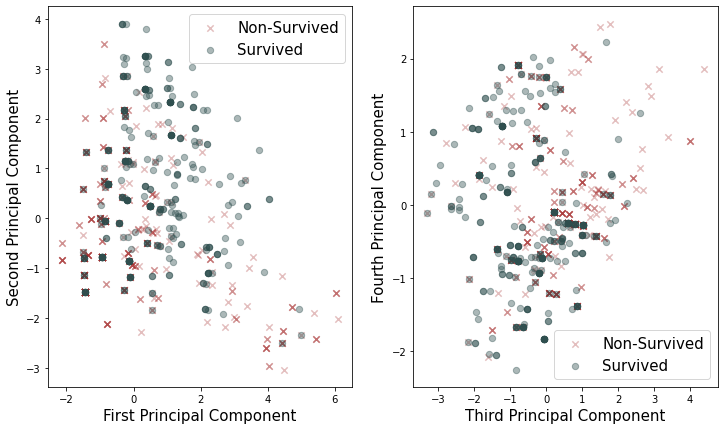

In [64]:
#Taking out 4 components
feature_scaled_pca_X0 = feature_scaled_pca[:,0]
feature_scaled_pca_X1 = feature_scaled_pca[:,1]
feature_scaled_pca_X2 = feature_scaled_pca[:,2]
feature_scaled_pca_X3 = feature_scaled_pca[:,3]

#Making dictionaies
labels=dfpca_target_list
colordict={0:'brown',1:'darkslategray'}
piclabel = {0:'Non-Survived', 1:'Survived'}
markers = {0:'x',1:'o'}
alphas={0:0.3,1:0.4}

fig = plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
for l in np.unique(labels):
    ix=np.where(labels==l)
    plt.scatter(feature_scaled_pca_X0[ix],feature_scaled_pca_X1[ix],
               c=colordict[l],label=piclabel[l],s=40,marker=markers[l],
               alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1=np.where(labels==l1)
    plt.scatter(feature_scaled_pca_X2[ix1],feature_scaled_pca_X3[ix1],
               c=colordict[l1],label=piclabel[l1],s=40,marker=markers[l1],
               alpha=alphas[l1])
plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("Fourth Principal Component", fontsize=15)
plt.legend(fontsize=15)

plt.show()

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(dfpca_d, dfpca_t,test_size=0.2,random_state=30)

In [59]:
#Creating Pipeline in which steps are StandardScaler, PCA and SVM
pipe_steps = [('scaler',StandardScaler()),('pca',PCA()),('SupVM',svm.SVC(kernel='rbf'))]
check_params = {
    'pca__n_components':[2,3,4,5],
    'SupVM__C':[0.1,0.5,1,10,30,40,50,75,100,500,1000],
    'SupVM__gamma':[0.01,0.05,0.07,0.1,0.5,1,5,10,50]
}
pipeline = Pipeline(pipe_steps)

In [60]:
from tqdm import tqdm as tqdm
print("Start Fitting Training Data")

for cv in tqdm(range(4,6)):
    create_grid = GridSearchCV(pipeline, param_grid = check_params, cv=cv)
    create_grid.fit(X_train, Y_train)
    print("Score for %d fold CV:= %3.2f" %(cv,create_grid.score(X_test,Y_test)))
    print("!!! Best - Fit Parameters from Training Data !!!")
    print(create_grid.best_params_)
    
print("Out Of The Loop")

  0%|                                                    | 0/2 [00:00<?, ?it/s]

Start Fitting Training Data


 50%|██████████████████████                      | 1/2 [01:17<01:17, 77.49s/it]

Score for 4 fold CV:= 0.79
!!! Best - Fit Parameters from Training Data !!!
{'SupVM__C': 50, 'SupVM__gamma': 0.01, 'pca__n_components': 5}


100%|████████████████████████████████████████████| 2/2 [02:42<00:00, 81.24s/it]

Score for 5 fold CV:= 0.79
!!! Best - Fit Parameters from Training Data !!!
{'SupVM__C': 0.1, 'SupVM__gamma': 0.5, 'pca__n_components': 5}
Out Of The Loop


In [74]:
print("Grid Best Params: ", create_grid.best_params_)

Grid Best Params:  {'SupVM__C': 500, 'SupVM__gamma': 50, 'pca__n_components': 2}


Confusion Matrix: 

[[92 16]
 [22 49]]


Text(0.5, 1.0, 'Confusion Matrix')

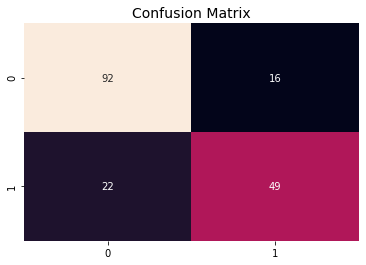

In [61]:
Y_pred = create_grid.predict(X_test)
cm=confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix: \n")
print(cm)

df_cm = pd.DataFrame(cm, range(2), range(2))

sns.heatmap(df_cm,annot=True,cbar=False)
plt.title("Confusion Matrix",fontsize=14)

In [62]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       108
         1.0       0.75      0.69      0.72        71

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



In [63]:
train_Y = dfpca_target[dfpca_target.isna()==False]
test_Y = dfpca_target[dfpca_target.isna()==True]

train_X = dfpca_data[:891]
test_X = dfpca_data[891:1310]

In [71]:
create_grid2 = GridSearchCV(pipeline, param_grid = check_params, cv=5)
create_grid2.fit(train_X, train_Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SupVM', SVC())]),
             param_grid={'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500,
                                      1000],
                         'SupVM__gamma': [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10,
                                          50],
                         'pca__n_components': [2, 3, 4, 5]})

In [72]:
pred_Y = create_grid2.predict(test_X)

In [78]:
submission_pca = pd.DataFrame({'PassengerId': test.PassengerId,
                          'Survived': pred_Y})
submission_pca.Survived = submission_pca.Survived.astype(int)

In [80]:
submission_pca.to_csv("submission_pca.csv",index=False)